# CAMVID Segmentation

## Import FastAI package

In [1]:
from fastai.vision.all import *

## Download CAMVID dataset

In [2]:
path = untar_data(URLs.CAMVID)

In [3]:
path.ls()

(#5) [Path('/home/gurucharan/.fastai/data/camvid/valid.txt'),Path('/home/gurucharan/.fastai/data/camvid/models'),Path('/home/gurucharan/.fastai/data/camvid/labels'),Path('/home/gurucharan/.fastai/data/camvid/codes.txt'),Path('/home/gurucharan/.fastai/data/camvid/images')]

In [4]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Dataloaders from DataBlock

In [5]:
dblock = DataBlock(blocks    = (ImageBlock, MaskBlock(codes)),
                   get_items = get_image_files,
                   splitter  = FileSplitter(path/'valid.txt'),
                   get_y     = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
                   batch_tfms=[*aug_transforms(size=(128,128)), Normalize.from_stats(*imagenet_stats)])
dls = dblock.dataloaders(path/"images", bs=8, path=path)
dls.vocab = codes

## Visualize dataset

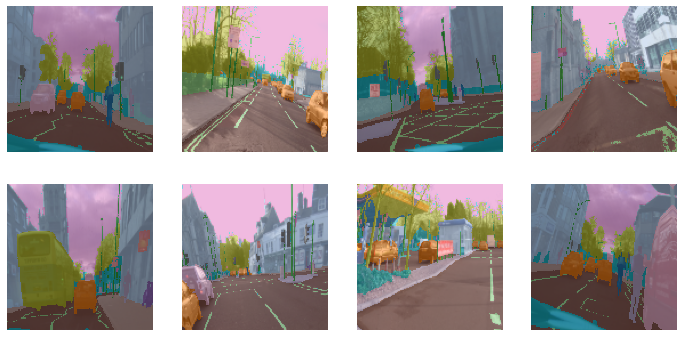

In [6]:
dls.show_batch()

## UNet Learner with pre-trained ResNet-18 encoder, deoder with Mish activation and self attention

In [7]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [8]:
learn = unet_learner(dls, resnet18, metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=ranger).to_fp16()

In [9]:
learn.summary()

DynamicUnet (Input shape: ['8 x 3 x 128 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               8 x 64 x 64 x 64     9,408      False     
________________________________________________________________
BatchNorm2d          8 x 64 x 64 x 64     128        True      
________________________________________________________________
ReLU                 8 x 64 x 64 x 64     0          False     
________________________________________________________________
MaxPool2d            8 x 64 x 32 x 32     0          False     
________________________________________________________________
Conv2d               8 x 64 x 32 x 32     36,864     False     
________________________________________________________________
BatchNorm2d          8 x 64 x 32 x 32     128        True      
________________________________________________________________
ReLU                 8 x 64 x 32 x 32     0          False     
_________________________________________________

/home/gurucharan/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.002290867641568184, lr_steep=0.002511886414140463)

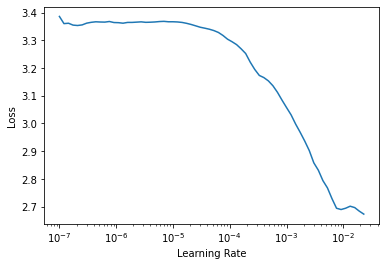

In [10]:
learn.lr_find(end_lr=10)

## Train for 10 epochs

In [11]:
lr = 1e-3
learn.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,1.267615,0.839411,0.799195,00:14
1,0.906906,0.698757,0.816939,00:14
2,0.760766,0.660222,0.824780,00:14
3,0.682075,0.573867,0.835507,00:14
4,0.636574,0.568584,0.835761,00:14
5,0.593238,0.513897,0.849514,00:15
6,0.554440,0.488725,0.854271,00:14
7,0.546890,0.453760,0.867844,00:14
8,0.495587,0.426363,0.879436,00:14
9,0.449957,0.405456,0.883374,00:14


In [12]:
learn.save('stage-1')

Path('/home/gurucharan/.fastai/data/camvid/models/stage-1.pth')

## Inference

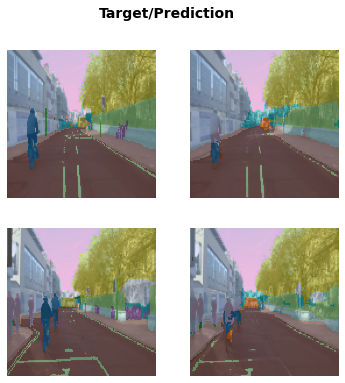

In [13]:
learn.show_results()

## Unfreeze and train

In [14]:
lrs = slice(lr/400, lr/4)
learn.unfreeze()
learn.fit_flat_cos(12, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.437544,0.406968,0.881728,00:15
1,0.425685,0.390481,0.887859,00:15
2,0.419125,0.391466,0.890101,00:15
3,0.411319,0.381501,0.890297,00:15
4,0.398969,0.377462,0.892854,00:15
5,0.393596,0.375137,0.894534,00:15
6,0.389611,0.374008,0.893649,00:15
7,0.375184,0.355483,0.899205,00:15
8,0.372986,0.383764,0.888727,00:15
9,0.365448,0.364654,0.896680,00:15


In [17]:
learn.save('stage_2')

Path('/home/gurucharan/.fastai/data/camvid/models/stage_2.pth')

## Inference

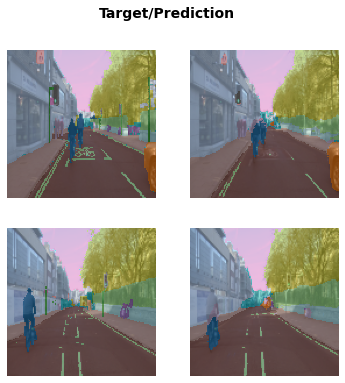

In [18]:
learn.show_results()